# PRISMO on Mouse Brain SlideSeqV2 Data from NSF paper

In [25]:
%load_ext autoreload
%autoreload 2

import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

import plotting_settings
from functools import partial
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from prismo import PRISMO
from prismo.pl import plot_weights
from plotnine import *
from data_loader import load_nsf_slideseq

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
data = load_nsf_slideseq()

In [43]:
model = PRISMO.load("models/prismo_10_1.h5")

In [44]:
factors = model.get_factors()["group_1"]
covariates = pd.DataFrame(model.covariates["group_1"], columns=["x", "y"], index=factors.index)

df = pd.concat([factors, covariates], axis=1)
df_long = pd.melt(df, id_vars=["x", "y"], var_name="Factor", value_name="Score")

df_long["Factor"] = pd.Categorical(df_long["Factor"], categories=df_long["Factor"].unique(), ordered=True)

df_long

,x,y,Factor,Score
0,-0.231938,1.503699,Factor 1,0.378692
1,-0.675580,-0.171828,Factor 1,0.121221
2,1.662255,0.426391,Factor 1,0.677418
3,1.656360,0.950393,Factor 1,0.675155
4,1.760463,-0.763073,Factor 1,0.134097
...,...,...,...,...
365355,-1.297624,-1.217838,Factor 10,0.788784
365356,1.581811,-0.802423,Factor 10,0.263543
365357,1.248499,0.470971,Factor 10,0.439592
365358,-0.721737,-0.734349,Factor 10,0.339004


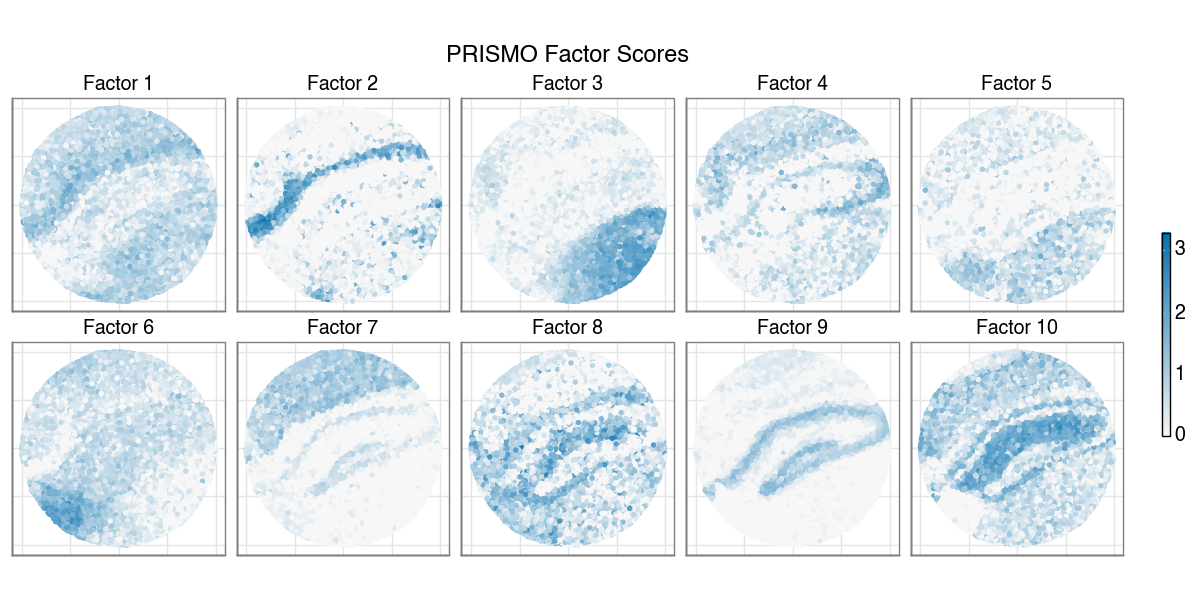

In [48]:
plot = (
    ggplot(df_long, aes(x="x", y="-y", color="Score"))
    + geom_point(size=0.1)
    + theme(
        figure_size=(6, 3),
        axis_text_x=element_blank(),
        axis_text_y=element_blank(),
        axis_ticks_major_x=element_blank(),
        axis_ticks_major_y=element_blank(),
        legend_key_width=3.,
    )
    + labs(x="", y="", color="", title="PRISMO Factor Scores")
    + coord_fixed(ratio=1)
    + scale_color_gradient(low="#f7f7f7", high="#0571b0")
    + facet_wrap("~Factor", ncol=5)
)
fig = plot.draw()
points = fig.axes[0].collections[0]
points.set_rasterized(True)
fig.savefig(f"plots/prismo_factor_scores.pdf")
plot.show()

/data/florin/prismo_project/prismo/src/prismo/pl/_plotting.py:787: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


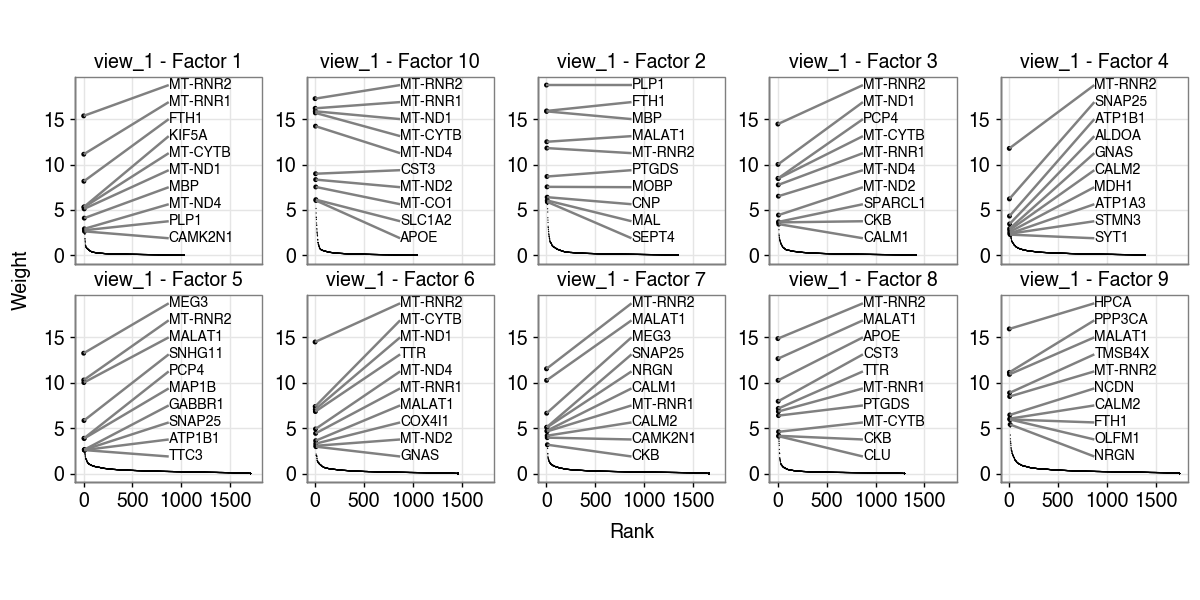

In [47]:
plot = plot_weights(model, ncols=5, figsize=(6, 3), pointsize=1)
fig = plot.draw()
fig.savefig(f"plots/prismo_weights.pdf")
plot.show()